In this notebook i will follow the instructions in this video and adapt based on or proect and preferences : https://www.youtube.com/watch?v=p_6kULimQvI

In [1]:
pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U numpy


  Using cached numpy-1.25.1-cp311-cp311-win_amd64.whl (15.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\matheus.fidelis\\AppData\\Local\\anaconda3\\Lib\\site-packages\\~=mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

  Using cached numpy-1.24.3-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.


In [6]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import GRU, Dense

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt



In [36]:
# Loading the data
dataset = pd.read_csv('..\cleaned-data\ethereum-pools-volume-cleaned.csv')

In [37]:
# Split column 'Pool-Name' into three columns: 'Token_1', 'Token_2' and 'Fee's'
crypto_info = dataset['Pool-Name'].str.split(' ', n=2, expand=True)
dataset['Token_1'] = crypto_info[0]
dataset['Token_2'] = crypto_info[2].str.split(' ', n=1, expand=True)[0]

# Create columns for each rate type
dataset['fee_0.01%'] = 0
dataset['fee_0.05%'] = 0
dataset['fee_0.3%'] = 0
dataset['fee_1%'] = 0

# Assign the correct values to the fee columns
dataset.loc[dataset['Pool-Name'].str.contains('0.01%'), 'fee_0.01%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.05%'), 'fee_0.05%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.3%'), 'fee_0.3%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('1%'), 'fee_1%'] = 1

# printing to see the results
dataset

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,DAI,ETH,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,DAI,ETH,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,DAI,ETH,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,DAI,ETH,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,DAI,ETH,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,ETH,USDC,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,ETH,USDC,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,ETH,USDC,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,ETH,USDC,0,1,0,0


In [39]:
# Token-to-number mapping dictionary
token_dict = {'DAI': 0, 'ETH': 1, 'LUSD': 2, 'USDC': 3, 'UDT': 4, 'MATIC': 5, 'WBTC': 6, 'USDT': 7, 'LINK': 8, 'OP': 9, 'ARB': 10, 'WETH': 11, 'BUSD': 12, 'BNB': 13}

# Mapping tokens to numbers in column 'Token_1'
dataset['Token_1'] = dataset['Token_1'].map(token_dict)

# Mapping tokens to numbers in column 'Token_2'
dataset['Token_2'] = dataset['Token_2'].map(token_dict)

dataset


,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,1,3,0,1,0,0


In [40]:
# Removing the column 'Pool-Name' because the infos are now splited
dataset = dataset.drop(columns=['Pool-Name'])
dataset

,daily_volume,time,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,3.754934e+11,1,3,0,1,0,0


In [41]:
# Convert 'time' column to datetime format
dataset['time'] = pd.to_datetime(dataset['time'])

# Set 'time' column as the index of the DataFrame
dataset.set_index('time', inplace=True)
dataset

,daily_volume,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
time,,,,,,,,,
2021-05-05 00:00:00+00:00,8.568270e+04,8.568270e+04,8.568270e+04,0,1,0,1,0,0
2021-05-06 00:00:00+00:00,1.431467e+06,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2021-05-07 00:00:00+00:00,8.459799e+06,9.976948e+06,9.976948e+06,0,1,0,1,0,0
2021-05-08 00:00:00+00:00,6.341874e+06,1.631882e+07,1.631882e+07,0,1,0,1,0,0
2021-05-09 00:00:00+00:00,2.707201e+05,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2023-05-22 00:00:00+00:00,1.432193e+08,3.750031e+11,3.750031e+11,1,3,0,1,0,0
2023-05-23 00:00:00+00:00,1.514438e+08,3.751546e+11,3.751546e+11,1,3,0,1,0,0
2023-05-24 00:00:00+00:00,1.956226e+08,3.753502e+11,3.753502e+11,1,3,0,1,0,0


In [42]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Print the normalized data
print(scaled_data)

[[2.65789325e-05 2.28026061e-07 2.28026061e-07 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44049152e-04 4.03908420e-06 4.03908420e-06 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.62427965e-03 2.65619867e-05 2.65619867e-05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.06832882e-02 9.99311671e-01 9.99311671e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44286309e-02 9.99692980e-01 9.99692980e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.57727157e-02 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


# Gru model

In [49]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 15

In [50]:

# Modificar para usar todas as colunas do conjunto de dados
X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)


In [51]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (12022, 15)
y_train:  (12022,)
X_test:  (2994, 15)
y_test (2994,)


In [52]:
model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 15, 32)            3360      
                                                                 
 gru_13 (GRU)                (None, 32)                6336      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
376/376 [==============================] - 7s 8ms/step - loss: 2.4549e-04 - val_loss: 0.0018
Epoch 2/200
376/376 [==============================] - 2s 7ms/step - loss: 2.1828e-04 - val_loss: 0.0019
Epoch 3/200
376/376 [==============================] - 2s 7ms/step - loss: 2.1239e-04 - val_loss: 0.0015
Epoch 4/200
376/376 [==============================] - 2s 7ms/step - loss: 2.0841e-04 - val_loss: 0.0014
Epoch 5/200
376/376 [==============================] - 2s 7ms/step - loss: 2.0616e-04 - val_loss: 0.0014
Epoch 6/200
376/376 [==============================] - 2s 7ms/step - loss: 2.0442e-04 - val_loss: 0.0014
Epoch 7/200
376/376 [==============================] - 2s 7ms/step - loss: 2.0224e-04 - val_loss: 0.0014
Epoch 8/200
376/376 [==============================] - 2s 6ms/step - loss: 2.0093e-04 - val_loss: 0.0014
Epoch 9/200
376/376 [==============================] - 2s 6ms/step - loss: 2.0232e-04 - val_loss: 0.0015
Epoch 10/200
376/376 [==============================] -

Epoch 155/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8856e-04 - val_loss: 0.0018
Epoch 156/200
376/376 [==============================] - 2s 7ms/step - loss: 1.8807e-04 - val_loss: 0.0019
Epoch 157/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8657e-04 - val_loss: 0.0019
Epoch 158/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8690e-04 - val_loss: 0.0023
Epoch 159/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8800e-04 - val_loss: 0.0018
Epoch 160/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8748e-04 - val_loss: 0.0020
Epoch 161/200
376/376 [==============================] - 2s 7ms/step - loss: 1.8746e-04 - val_loss: 0.0019
Epoch 162/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8660e-04 - val_loss: 0.0022
Epoch 163/200
376/376 [==============================] - 3s 7ms/step - loss: 1.8612e-04 - val_loss: 0.0019
Epoch 164/200
376/376 [==============

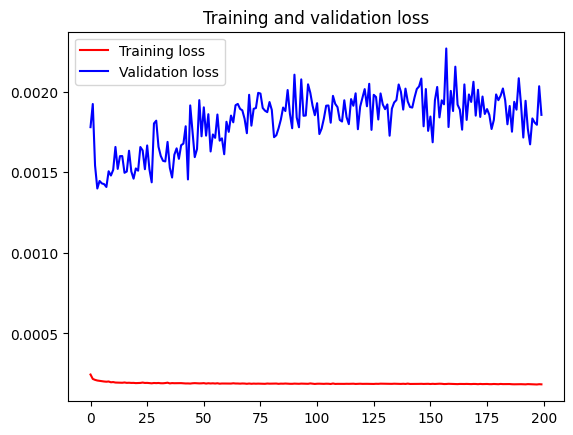

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [28]:
time_step = 15

# Modificar para usar todas as colunas do conjunto de dados
X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (12022, 15)
y_train:  (12022,)
X_test:  (2994, 15)
y_test (2994,)


In [29]:
model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
376/376 [==============================] - 6s 9ms/step - loss: 2.3790e-04 - val_loss: 0.0015
Epoch 2/200
376/376 [==============================] - 2s 6ms/step - loss: 2.1299e-04 - val_loss: 0.0014
Epoch 3/200
376/376 [==============================] - 2s 6ms/step - loss: 2.1069e-04 - val_loss: 0.0015
Epoch 4/200
376/376 [==============================] - 2s 6ms/step - loss: 2.1127e-04 - val_loss: 0.0014
Epoch 5/200
376/376 [==============================] - 2s 7ms/step - loss: 2.0582e-04 - val_loss: 0.0014
Epoch 6/200
376/376 [==============================] - 3s 7ms/step - loss: 2.0085e-04 - val_loss: 0.0017
Epoch 7/200
376/376 [==============================] - 3s 7ms/step - loss: 2.0023e-04 - val_loss: 0.0014
Epoch 8/200
376/376 [==============================] - 2s 7ms/step - loss: 2.0112e-04 - val_loss: 0.0015
Epoch 9/200
376/376 [==============================] - 3s 7ms/step - loss: 1.9920e-04 - val_loss: 0.0015
Epoch 10/200
376/376 [==============================] -

Epoch 155/200
376/376 [==============================] - 2s 6ms/step - loss: 1.8706e-04 - val_loss: 0.0019
Epoch 156/200
376/376 [==============================] - 2s 6ms/step - loss: 1.8738e-04 - val_loss: 0.0021
Epoch 157/200
376/376 [==============================] - 2s 6ms/step - loss: 1.8731e-04 - val_loss: 0.0018
Epoch 158/200
376/376 [==============================] - 2s 7ms/step - loss: 1.8646e-04 - val_loss: 0.0020
Epoch 159/200
376/376 [==============================] - 2s 6ms/step - loss: 1.8657e-04 - val_loss: 0.0019
Epoch 160/200
376/376 [==============================] - 2s 6ms/step - loss: 1.8655e-04 - val_loss: 0.0019
Epoch 161/200
376/376 [==============================] - 2s 7ms/step - loss: 1.8692e-04 - val_loss: 0.0018
Epoch 162/200
376/376 [==============================] - 2s 6ms/step - loss: 1.8796e-04 - val_loss: 0.0020
Epoch 163/200
376/376 [==============================] - 2s 7ms/step - loss: 1.8643e-04 - val_loss: 0.0020
Epoch 164/200
376/376 [==============

In [19]:


# Criação das sequências de entrada e saída
def create_sequences(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i : (i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 15
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Definição do modelo GRU
model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(time_steps, 1)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilação do modelo
model.compile(loss='mean_squared_error', optimizer='adam')




In [20]:
# Treinamento do modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)


Epoch 1/200


ValueError: in user code:

    File "C:\Users\matheus.fidelis\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\matheus.fidelis\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\matheus.fidelis\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\matheus.fidelis\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\matheus.fidelis\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\matheus.fidelis\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "gru_3" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 15, 9)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 15, 9), dtype=float32)
      • training=True
      • mask=None


In [ ]:

# Avaliação do modelo
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Cálculo das métricas
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

In [ ]:
# Determine the split point for 80% of the data
split_point = int(len(scaled_data) * 0.6)

# Split the data into training and test sets
train, test = scaled_data[:split_point], scaled_data[split_point:]


# Print the number of items in each set
print('Training set: ', len(train))
print('Test set: ', len(test))

In [ ]:
# Set the length of the sequence
seq_length = 10

# Function to create time sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create time sequences for training
X_train, y_train = create_sequences(train, seq_length)
# Create time sequences for testing
X_test, y_test = create_sequences(test, seq_length)

In [ ]:
# Defines the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))

# Compiles the template
model.compile(optimizer='adam', loss='mse')


In [ ]:
# Displays the summary of the model
model.summary()

Batch size determines how many training examples are processed in each iteration of gradient descent. A larger batch size can reduce the gradient variance and potentially accelerate convergence. However, it may require more memory and slow down training.

The number of epochs represents the number of times the entire training dataset is passed through the model. Increasing the number of epochs allows the model to better fit the training data, but it also increases the risk of overfitting, where the model becomes too specific to the training data and performs poorly on unseen data. Conversely, using fewer epochs may result in underfitting, where the model fails to capture complex patterns in the data.

In [128]:
# Train the model with validation data
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test, y_test))

# Get the model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Adjust the dimensions of y_train and y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


Epoch 1/100
132/141 [===========================>..] - ETA: 0s - loss: 0.0950

ValueError: Data cardinality is ambiguous:
  x sizes: 6010
  y sizes: 54090
Make sure all arrays contain the same number of samples.

In [ ]:
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

In [ ]:
# Resize y_train to have the same number of samples as X_train
y_train = y_train[:X_train.shape[0]]

# Verify again
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Epoch 1/100
141/141 [==============================] - 2s 15ms/step - loss: 0.0952 - val_loss: 0.1697
Epoch 2/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0948 - val_loss: 0.1699
Epoch 3/100
141/141 [==============================] - 1s 7ms/step - loss: 0.0946 - val_loss: 0.1700
Epoch 4/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0946 - val_loss: 0.1691
Epoch 5/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0947 - val_loss: 0.1699
Epoch 6/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0947 - val_loss: 0.1694
Epoch 7/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0946 - val_loss: 0.1697
Epoch 8/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0946 - val_loss: 0.1703
Epoch 9/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0947 - val_loss: 0.1697
Epoch 10/100
141/141 [==============================] - 1s 6ms/step - loss: 0.0947 - val_l

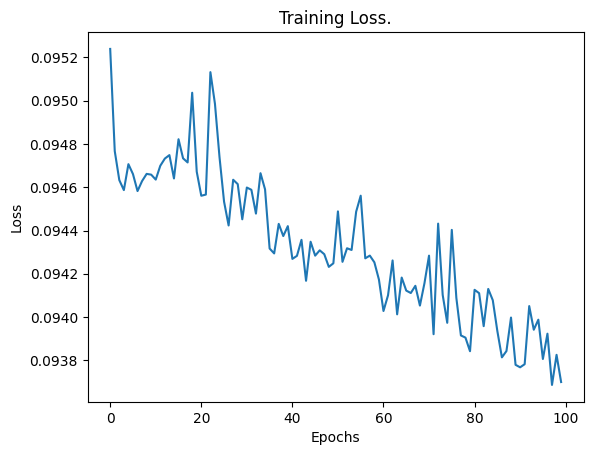

In [143]:
# Train the model with validation
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

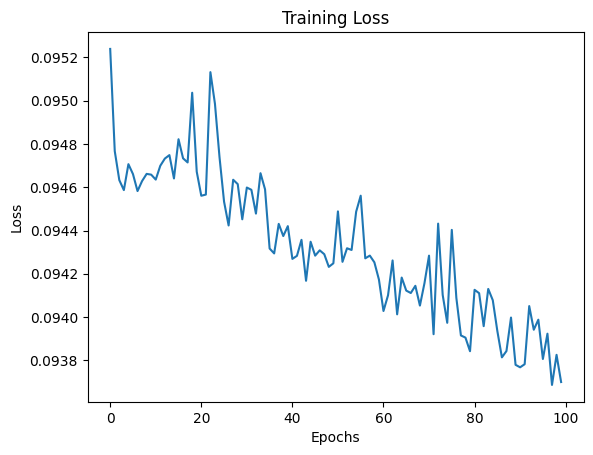

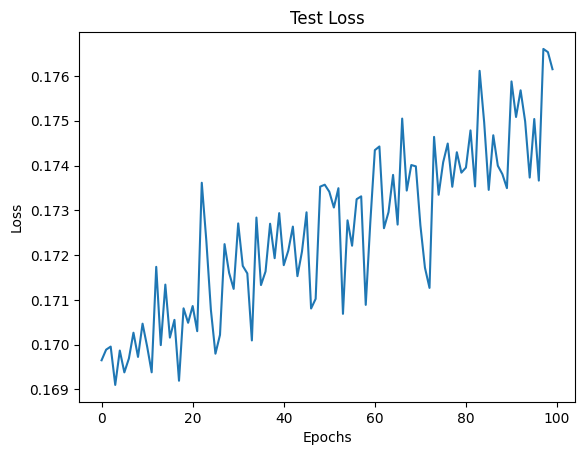

In [144]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the test loss
plt.plot(history.history['val_loss'])
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


The "epoch" represents a complete iteration of the training data, the "training loss" is the metric that quantifies the error during training, and the "loss" graph shows the variation of the loss over epochs.

In [130]:
# Get model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reshape the dimensions of y_train and y_test arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Resize train_predictions
train_predictions = train_predictions[:len(y_train)]

# Resize test_predictions
test_predictions = test_predictions[:len(y_test)]

# Resize y_train to have the same number of samples as train_predictions
y_train = y_train[:len(train_predictions)]

# Resize y_test to have the same number of samples as test_predictions
y_test = y_test[:len(test_predictions)]

# Verify shapes
print(y_test.shape)
print(test_predictions.shape)



188/188 [==============================] - 0s 2ms/step
(6010, 1)
(6010, 1)


Isso significa que você tem 3000 amostras tanto para y_test (valores reais) quanto para test_predictions (valores previstos pelo modelo). Essas dimensões são consistentes e adequadas para calcular as métricas de erro.

Portanto, você pode prosseguir utilizando os valores calculados train_mae, train_mse, test_mae e test_mse para avaliar o desempenho do seu modelo em termos de erro absoluto médio (MAE) e erro quadrático médio (MSE).


(3000, 1)" indica a forma (shape) dos arrays y_test e test_predictions. Ambos têm 3000 amostras e 1 dimensão.

# Metricas de avaliação do modelo

Mean Absolute Error (MAE): O erro médio absoluto mede a média das diferenças absolutas entre as previsões e os valores reais. Quanto menor o valor do MAE, melhor o desempenho do modelo.



Mean Squared Error (MSE): O erro médio quadrático mede a média dos quadrados das diferenças entre as previsões e os valores reais. É uma métrica amplamente usada que penaliza erros maiores mais fortemente do que o MAE.



In [131]:
# Calculate training set errors
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)


In [132]:
# Calculate test set errors
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

In [133]:
# Printing test and train
print(train_mae)
print(test_mae)
print(train_mse) 
print(test_mse)

0.2003145534254617
0.2682942687970267
0.09464066476688443
0.168675336194286


In [134]:
print("train_mae:", train_mae)
print("test_mae:", test_mae)
print("train_mse:", train_mse)
print("test_mse:", test_mse)


train_mae: 0.2003145534254617
test_mae: 0.2682942687970267
train_mse: 0.09464066476688443
test_mse: 0.168675336194286


In [135]:
print("train_mae type:", type(train_mae))
print("test_mae type:", type(test_mae))
print("train_mse type:", type(train_mse))
print("test_mse type:", type(test_mse))


train_mae type: <class 'numpy.float64'>
test_mae type: <class 'numpy.float64'>
train_mse type: <class 'numpy.float64'>
test_mse type: <class 'numpy.float64'>


In [136]:
train_mae = [train_mae]  # Convert to list
test_mae = [test_mae]  # Convert to list
train_mse = [train_mse]  # Convert to list
test_mse = [test_mse]  # Convert to list

In [137]:
# Priting to see if now they are a list
print("train_mae type:", type(train_mae))
print("test_mae type:", type(test_mae))
print("train_mse type:", type(train_mse))
print("test_mse type:", type(test_mse))


train_mae type: <class 'list'>
test_mae type: <class 'list'>
train_mse type: <class 'list'>
test_mse type: <class 'list'>


In [138]:
# Definition of the calculate_mae function

def calculate_mae(predictions, labels):
    return np.mean(np.abs(predictions - labels))

# Definition of the calculate_mse function
def calculate_mse(predictions, labels):
    return np.mean(np.square(predictions - labels))

train_data = X_train  # Replace X_train with your training data
train_labels = y_train  # Replace y_train with your training labels
test_data = X_test  # Replace X_test with your test data
test_labels = y_test  # Replace y_test with your test labels

num_epochs = 10

train_mae = []
test_mae = []
train_mse = []
test_mse = []

# Model training loop
for epoch in range(num_epochs):
      # Model training
    model.fit(train_data, train_labels)
    
    # Model evaluation
    train_predictions = model.predict(train_data)
    test_predictions = model.predict(test_data)
    
    # Calculation of MAE and MSE
    train_mae_value = calculate_mae(train_predictions, train_labels)
    test_mae_value = calculate_mae(test_predictions, test_labels)
    train_mse_value = calculate_mse(train_predictions, train_labels)
    test_mse_value = calculate_mse(test_predictions, test_labels)

    # Update of MAE and MSE values
    train_mae.append(train_mae_value)
    test_mae.append(test_mae_value)
    train_mse.append(train_mse_value)
    test_mse.append(test_mse_value)


188/188 [==============================] - 0s 2ms/step


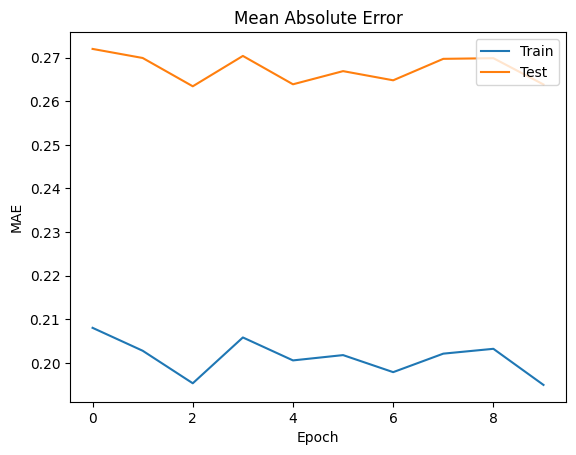

In [139]:
# Plot training and test MAE
plt.plot(train_mae)
plt.plot(test_mae)
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

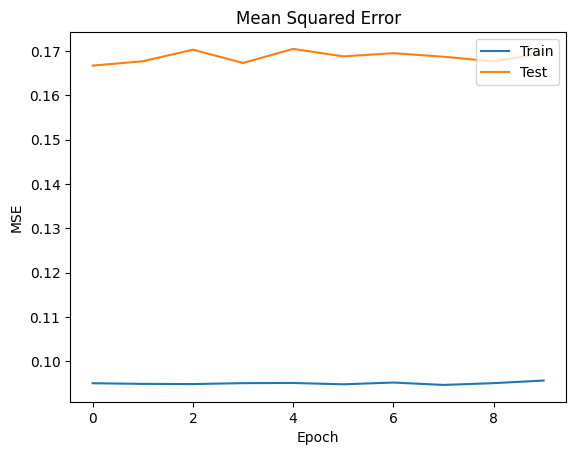

In [140]:
# Plot training and test MSE
plt.plot(train_mse)
plt.plot(test_mse)
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [141]:
print(train_mae)
print(test_mae)
print(train_mse) 
print(test_mse)

[0.20804080959987295, 0.2027851272406064, 0.19532421762814253, 0.20583291095916897, 0.20057046982609092, 0.20178630457128405, 0.19787784536725408, 0.20211880060689252, 0.20322933058530188, 0.1949482724568535]
[0.2719993805579313, 0.26992183957930294, 0.2634302388206392, 0.27039144096457957, 0.2638881162385306, 0.26690690984101945, 0.2648036913944419, 0.2697235683594858, 0.26987535835629817, 0.2638474016865145]
[0.09499734349968166, 0.09485294390417968, 0.09481118541976002, 0.0950174788446862, 0.09506001590832801, 0.09475481518343866, 0.09515508866796218, 0.0946163937072116, 0.09501585139195468, 0.0956006829827945]
[0.16673416309107345, 0.16770894521833868, 0.17032940349789102, 0.16732261481718408, 0.17049850165843436, 0.16881874427611995, 0.1695319911402881, 0.1687399415317878, 0.16767587599126263, 0.16952517964484143]


In [142]:
# Importar a métrica de EVS
from sklearn.metrics import explained_variance_score

# Calcular o EVS para os dados de treinamento
train_evs = explained_variance_score(y_train, train_predictions)

# Calcular o EVS para os dados de teste
test_evs = explained_variance_score(y_test, test_predictions)

# Imprimir os resultados
print('Explained Variance Score (Train):', train_evs)
print('Explained Variance Score (Test):', test_evs)


Explained Variance Score (Train): 0.025402561117413236
Explained Variance Score (Test): -0.03384178318378139


In [ ]:
from sklearn.metrics import accuracy_score

# Faz as previsões no conjunto de teste
test_predictions = model.predict(X_test)

# Calcula a precisão 
accuracy = accuracy_score(y_test, test_predictions)

print(f"A precisão no conjunto de teste é: {accuracy}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Arredondar as previsões para a classe mais próxima (0 ou 1)
train_predictions_rounded = np.round(train_predictions).flatten()
test_predictions_rounded = np.round(test_predictions).flatten()

# Arredondar os rótulos reais para a classe mais próxima (0 ou 1)
y_train_rounded = y_train.flatten()
y_test_rounded = y_test.flatten()

# Converter as previsões e rótulos para inteiros
train_predictions_int = train_predictions_rounded.astype(int)
test_predictions_int = test_predictions_rounded.astype(int)
y_train_int = y_train_rounded.astype(int)
y_test_int = y_test_rounded.astype(int)

# Calcular as métricas de acurácia, precisão e recall
train_accuracy = accuracy_score(y_train_int, train_predictions_int)
train_precision = precision_score(y_train_int, train_predictions_int)
train_recall = recall_score(y_train_int, train_predictions_int)

test_accuracy = accuracy_score(y_test_int, test_predictions_int)
test_precision = precision_score(y_test_int, test_predictions_int)
test_recall = recall_score(y_test_int, test_predictions_int)

# Imprimir as métricas
print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
